In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

C:\Users\w\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\w\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
os.getcwd()

'C:\\Users\\w\\Documents\\Airbnb'

In [3]:
LISTINGSFILE = 'data\listingsHK.csv'

cols = ['price',
        'accommodates',
        'bedrooms',
        'beds',
        'neighbourhood_cleansed',
        'room_type',
        'cancellation_policy',
        'instant_bookable',
        'reviews_per_month',
        'number_of_reviews',
        'availability_30',
        'review_scores_rating'
        ]

# read the file into a dataframe
df = pd.read_csv(LISTINGSFILE, usecols=cols)
len(df.index)

6474

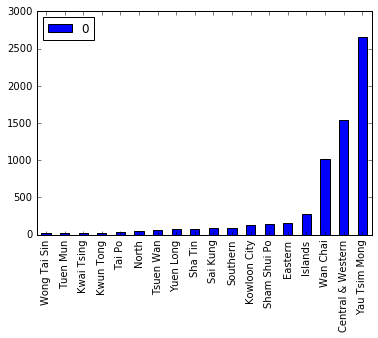

In [4]:
nb_counts = Counter(df.neighbourhood_cleansed)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

In [5]:
# the number of entries with 0 'number_of_reviews' which do not a NaN for 'reviews_per_month'
len(df[(df.number_of_reviews == 0) & (pd.isnull(df.number_of_reviews) == False)
       & (pd.isnull(df.reviews_per_month) == False)].index)

0

In [6]:
# the number of entries with at least 1 'number_of_reviews' which have a NaN for 'reviews_per_month'
len(df[(df.number_of_reviews != 0) & (pd.isnull(df.number_of_reviews) == False)
       & (pd.isnull(df.reviews_per_month) == True)].index)

0

In [7]:
# so we need to do some cleaning.

# first fixup 'reviews_per_month' where there are no reviews
df['reviews_per_month'].fillna(0, inplace=True)

# just drop rows with bad/weird values
# (we could do more here)
df = df[df.bedrooms != 0]
df = df[df.beds != 0]
df = df[df.price != 0]
df = df.dropna(axis=0)

len(df.index)

4104

In [9]:
# remove the $ from the price and convert to float
df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)
df.price.head(5)

2    248.0
4    302.0
7    216.0
8    184.0
9    302.0
Name: price, dtype: float64

In [12]:
# get feature encoding for categorical variables
n_dummies = pd.get_dummies(df.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(df.room_type)
xcl_dummies = pd.get_dummies(df.cancellation_policy)

# convert boolean column to a single boolean value indicating whether this listing has instant booking available
ib_dummies = pd.get_dummies(df.instant_bookable, prefix="instant")
ib_dummies = ib_dummies.drop('instant_f', axis=1)

# replace the old columns with our new one-hot encoded ones
alldata = pd.concat((df.drop(['neighbourhood_cleansed', \
    'room_type', 'cancellation_policy', 'instant_bookable'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int), \
    xcl_dummies.astype(int), ib_dummies.astype(int)), \
    axis=1)
allcols = alldata.columns
alldata.head(5)

,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,Central & Western,Eastern,...,Wong Tai Sin,Yau Tsim Mong,Yuen Long,Entire home/apt,Private room,Shared room,flexible,moderate,strict,instant_t
2,1,1.0,1.0,248.0,15,2,100.0,0.19,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,1.0,1.0,302.0,30,26,95.0,0.57,0,0,...,0,0,0,0,1,0,0,1,0,0
7,1,1.0,1.0,216.0,30,2,100.0,0.61,0,0,...,0,0,0,0,1,0,1,0,0,0
8,1,1.0,1.0,184.0,30,1,80.0,0.03,0,0,...,0,0,0,0,1,0,1,0,0,0
9,1,1.0,1.0,302.0,6,3,90.0,0.11,0,0,...,0,0,0,0,1,0,1,0,0,0


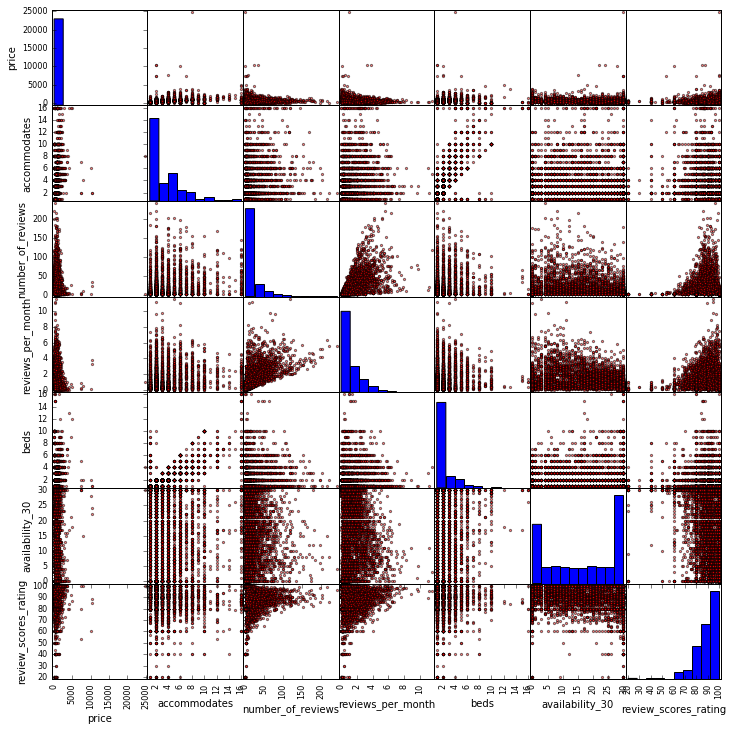

In [13]:
scattercols = ['price','accommodates', 'number_of_reviews', 'reviews_per_month', 'beds', 'availability_30', 'review_scores_rating']
axs = pd.scatter_matrix(alldata[scattercols],
                        figsize=(12, 12), c='red')

In [14]:
traindata=alldata.drop(['price'],axis=1)
traindata.head(5)

,accommodates,bedrooms,beds,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,Central & Western,Eastern,Islands,...,Wong Tai Sin,Yau Tsim Mong,Yuen Long,Entire home/apt,Private room,Shared room,flexible,moderate,strict,instant_t
2,1,1.0,1.0,15,2,100.0,0.19,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,1.0,1.0,30,26,95.0,0.57,0,0,0,...,0,0,0,0,1,0,0,1,0,0
7,1,1.0,1.0,30,2,100.0,0.61,0,0,0,...,0,0,0,0,1,0,1,0,0,0
8,1,1.0,1.0,30,1,80.0,0.03,0,0,0,...,0,0,0,0,1,0,1,0,0,0
9,1,1.0,1.0,6,3,90.0,0.11,0,0,0,...,0,0,0,0,1,0,1,0,0,0


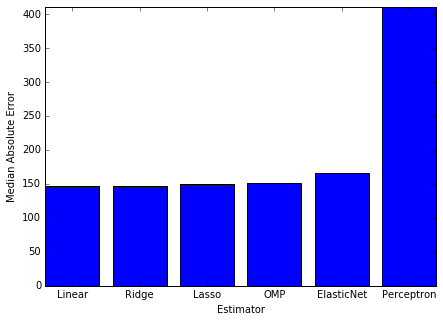

In [15]:
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.Perceptron(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'Perceptron', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test =train_test_split(traindata,alldata['price'],test_size=0.2, random_state=1)
for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')
plt.margins(0,.0)

In [16]:
n_est = 300
tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 1 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='lad', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=1, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [17]:
abs(clf.best_score_)

106.44988099452414

In [21]:
#divide the data by the number of beds to see if we can get better result
df2 = df[df.bedrooms == 1]
len(df2.index)

3057

In [24]:
# get feature encoding for categorical variables
n_dummies = pd.get_dummies(df2.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(df2.room_type)
xcl_dummies = pd.get_dummies(df2.cancellation_policy)

# convert boolean column to a single boolean value indicating whether this listing has instant booking available
ib_dummies = pd.get_dummies(df2.instant_bookable, prefix="instant")
ib_dummies = ib_dummies.drop('instant_f', axis=1)

# replace the old columns with our new one-hot encoded ones
alldata2 = pd.concat((df2.drop(['neighbourhood_cleansed', \
    'room_type', 'cancellation_policy', 'instant_bookable'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int), \
    xcl_dummies.astype(int), ib_dummies.astype(int)), \
    axis=1)
allcols = alldata2.columns
alldata2.head(5)

,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,Central & Western,Eastern,...,Wong Tai Sin,Yau Tsim Mong,Yuen Long,Entire home/apt,Private room,Shared room,flexible,moderate,strict,instant_t
2,1,1.0,1.0,248.0,15,2,100.0,0.19,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,1.0,1.0,302.0,30,26,95.0,0.57,0,0,...,0,0,0,0,1,0,0,1,0,0
7,1,1.0,1.0,216.0,30,2,100.0,0.61,0,0,...,0,0,0,0,1,0,1,0,0,0
8,1,1.0,1.0,184.0,30,1,80.0,0.03,0,0,...,0,0,0,0,1,0,1,0,0,0
9,1,1.0,1.0,302.0,6,3,90.0,0.11,0,0,...,0,0,0,0,1,0,1,0,0,0


In [25]:
traindata2=alldata2.drop(['price'],axis=1)
traindata2.head(5)

,accommodates,bedrooms,beds,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,Central & Western,Eastern,Islands,...,Wong Tai Sin,Yau Tsim Mong,Yuen Long,Entire home/apt,Private room,Shared room,flexible,moderate,strict,instant_t
2,1,1.0,1.0,15,2,100.0,0.19,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,1.0,1.0,30,26,95.0,0.57,0,0,0,...,0,0,0,0,1,0,0,1,0,0
7,1,1.0,1.0,30,2,100.0,0.61,0,0,0,...,0,0,0,0,1,0,1,0,0,0
8,1,1.0,1.0,30,1,80.0,0.03,0,0,0,...,0,0,0,0,1,0,1,0,0,0
9,1,1.0,1.0,6,3,90.0,0.11,0,0,0,...,0,0,0,0,1,0,1,0,0,0


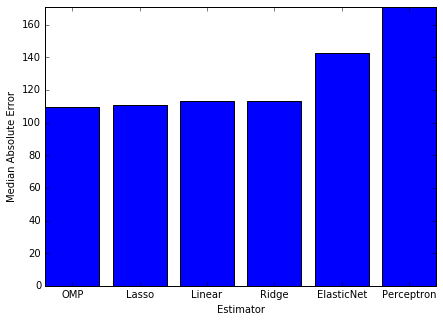

In [26]:
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.Perceptron(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'Perceptron', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test =train_test_split(traindata2,alldata2['price'],test_size=0.2, random_state=1)
for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')
plt.margins(0,.0)

In [27]:
n_est = 300
tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 1 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='lad', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=1, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [28]:
abs(clf.best_score_)

87.01480541648432

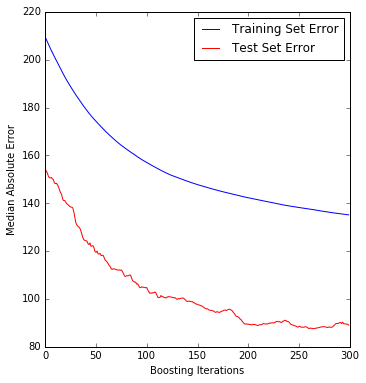

In [44]:
# plot error for each round of boosting
test_score = np.zeros(n_est, dtype=np.float64)

for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = metrics.median_absolute_error(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), best.train_score_, 'b-', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'r-', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Median Absolute Error')

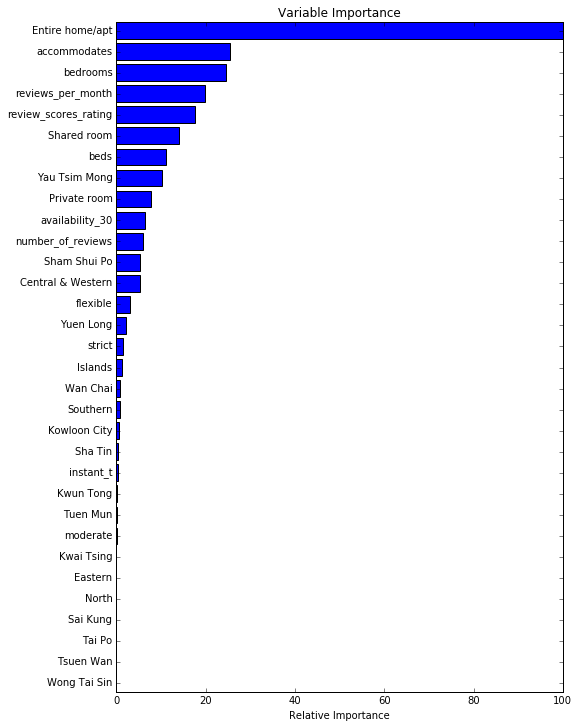

In [17]:
feature_importance = clf.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.margins(0,.0)